__Visualizing Life Satisfaction on GDP per capita and Gini index data__


__Table of Contents__

1) Intentions / Choosing a Dataset

2) Cleaning Data

3) Visualizing Data

    a) Choropleth Map
    
    b) Scatterplots for individual countries
    
    c) Scatterplot comparing all countries
  
4) Conclusion

In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pycountry_convert as pc

__1) Intentions / Choosing a Dataset__


The aim of this visualization project was to show the relationship between Life Satisfaction in combination with both GDP per capita and Gini index. Specifically showing in what ways geography, wealth, inequality as well as developments in these areas could influence life satisfaction of a society in a relatively short timeframe (ten years). The target audience would be social scientists, perhaps in the context of an academic publication. The intention was to create graphs that were relatively easy to read, while being information dense. 

To begin with, the data was loaded and merged into a single Pandas dataframe. The data consisted of two datasets, the "gdp-vs-happiness" dataset and the "economic-inequality-gini-index" dataset, which were both taken from "Our World in Data" (https://ourworldindata.org/). Life Satisfaction measures were taken from the World Happiness Report using the Cantril Ladder (“Please imagine a ladder, with steps numbered from 0 at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?”). The Gini coefficient measures inequality of income or wealth on a scale from 0 to 100 (0 expresses perfect equality (i.e. where everyone has the same income) and 100 expresses maximal inequality (i.e. for a large number of people where only one person has all the income or consumption and all others have none). Gini is one of the most widely used measures of income inequality. It's characteristics make it particularly useful for making comparisons over time and between countries. It has been proposed by several social scientist as an indicator of happiness and this projects intends to explore this hypothesis visually in combination with Life Satisfaction measured on the Cantril Ladder.

Once merged, the dataset contained 4197 rows of data for 164 countries spanning 39 years from 1981 until 2019. Apart from country name, country code and year, this included data on Life Satisfaction, GDP at purchasing power parity per capita in U.S. Dollars, population size, continent and Gini index.

In [3]:
df = pd.read_csv("gdp-vs-happiness.csv")
df_gini = pd.read_csv("economic-inequality-gini-index.csv")
df = pd.merge(df, df_gini)
print("Once merged, the dataset contains " +str(len(df))+ " rows of data for " +str(df['Entity'].nunique())+ 
      " countries spanning " +str(df['Year'].nunique())+ " years from " +str(sorted(df['Year'].unique())[0])+ 
      " until " +str(sorted(df['Year'].unique())[-1])+ ".")
df.head()

Once merged, the dataset contains 4197 rows of data for 164 countries spanning 39 years from 1981 until 2019.


,Entity,Code,Year,Life satisfaction in Cantril Ladder (World Happiness Report 2022),"GDP per capita, PPP (constant 2017 international $)",Population (historical estimates),Continent,Gini index
0,Albania,ALB,2005,4.634252,8040.878717,3086810.0,NaN,30.59566
1,Albania,ALB,2008,5.268937,9912.577242,3002683.0,NaN,29.98467
2,Albania,ALB,2012,4.813763,11227.994487,2914091.0,NaN,28.96048
3,Albania,ALB,2014,4.511101,11586.863767,2896307.0,NaN,34.59890
4,Albania,ALB,2015,4.639548,11878.488093,2890524.0,Europe,32.91291


__2) Cleaning Data__

After loading and merging the data, it had to be cleaned. The column containing continent data was dropped entirely as it contained only very few entries. A few of the longer column titles were renamed to ease the coding process. Values on Life Satisfaction and Gini index were rounded to 2 decimal places in order to enable easier grouping in visualizations, while maintaining enough information to show slight changes from year to year. GDP per capita was rounded to 0 decimal places to ease visualization. Finally, all missing values were dropped.

Once the data was cleaned, data for the years from 2008 to 2017 was selected. This was done for two reasons: 1) there was a lot of data available for these years 2) this specific time (post 2008 Global Financial Crisis) seemed a particularly interesting time to measure Life Satisfaction as it relates to GDP per capita and equality in society, as these variables were likely in fluctuation. Lastly a column containing continent data was added to allow for filtering.

In [4]:
df = df.drop(columns='Continent')
df.rename(columns = {'Life satisfaction in Cantril Ladder (World Happiness Report 2022)':'Life Satisfaction',
                     'GDP per capita, PPP (constant 2017 international $)':'GDP per capita',
                     'Population (historical estimates)': 'Population'}, inplace = True)
df["Life Satisfaction"] = df["Life Satisfaction"].round(2)
df['Gini index'] = df['Gini index'].round(2)
df['GDP per capita'] = df['GDP per capita'].round(0)
df = df.dropna()
df = df[df['Year'] > 2007]
df = df[df['Year'] <= 2017]
df['Continent'] = df['Code']
df['Continent'] = df['Continent'].apply(lambda x: pc.country_alpha3_to_country_alpha2(x))
df['Continent'] = df['Continent'].apply(lambda x: pc.country_alpha2_to_continent_code(x))

Once the initial stages of the cleaning process were done, two further filtering steps were taken in order to make sure that data was consistent across countries to allow for meaningul comparisons to be made.

In the first step, all data was dropped if there was less than 8 years of data available for individual countries for the years between 2008 and 2017. In this way, developments between years could be traced and compared accurately. 

Secondly, many country's Gini data wasn't recorded on a yearly basis, but was simply recorded once and then copied over a time span. To enable the tracing of developments over time, all countries in which Gini data between 2008 and 2017 wasn't uniquely recorded at least 8 seperate times were dropped.

After this second stage of cleaning, the dataset contained 568 rows of data for 58 countries spanning 10 years from 2008 until 2017. This stage of filtering unfortunately excluded a lot of data from countries in Africa, Asia and Australasia. While being aware of the drawbacks, such as the inability to reach conclusions about global realities and developments, this was an explicit choice to avoid making such claims on incomplete data. In this case, quality was chosen over quantity, allowing for more robust analysis of specific parts of the world.

In [5]:
years_of_data_available_per_country = df.groupby('Code')['Year'].nunique().to_frame()
years_of_data_available_per_country = years_of_data_available_per_country[years_of_data_available_per_country['Year'] >= 8]
years_of_data_available_per_country['Code'] = years_of_data_available_per_country.index
years_of_data_available_per_country.index.names = ['Index']
df_min_amount_of_data_available = pd.merge(df, years_of_data_available_per_country['Code'])

In [6]:
for i in range(len(years_of_data_available_per_country)):
    code = years_of_data_available_per_country.iloc[i]['Code']
    num_years = years_of_data_available_per_country.iloc[i]['Year']
    unique_ginis_by_country = df_min_amount_of_data_available[df_min_amount_of_data_available['Code'] == code]['Gini index'].nunique()
    if unique_ginis_by_country < 8:
        df_unique_ginis = df_min_amount_of_data_available.drop(df_min_amount_of_data_available[df_min_amount_of_data_available.Code == code].index)

In [7]:
print("After cleaning, the dataset contains " +str(len(df_unique_ginis))+
      " rows of data for " +str(df_unique_ginis['Entity'].nunique())+
      " countries spanning " +str(df_unique_ginis['Year'].nunique())+
      " years from " +str(sorted(df_unique_ginis['Year'].unique())[0])+
      " until " +str(sorted(df_unique_ginis['Year'].unique())[-1])+ ".")

After cleaning, the dataset contains 568 rows of data for 58 countries spanning 10 years from 2008 until 2017.


__3) Visualizing Data__

All visualizations were done using Plotly Express.

a) Choropleth Map

As the year 2013 provides the most data (58 countries, 55 Life Satisfaction entries, 58 GDP per capita entries, 58 population entries, 57 Gini index entries across 5 continents), a choropleth map provides a good picture of the extent of the data geographically in that year. Including a color scale for lifesatisfaction statistics also allows for an initial assessment of geographical distrubtion of the data. The colorscheme from blue to red to yellow scaled from 1 to 10, thereby consistent with the Cantril ladder scores from 1 to 10, clearly distinguishes country's life satisfaction on the map. Furthermore, the Gini index for each individual country can be viewed when hovering over the country. In this way, all data is combined on a map for the single year with the most datapoints.

In [8]:
df_unique_ginis.groupby("Year").nunique()

,Entity,Code,Life Satisfaction,GDP per capita,Population,Gini index,Continent
Year,,,,,,,
2008,54,54,51,54,54,54,4
2009,57,57,53,56,57,57,4
2010,56,56,53,56,56,55,5
2011,56,56,53,56,56,55,5
2012,58,58,53,58,58,58,5
2013,58,58,55,58,58,57,5
2014,58,58,52,58,58,58,5
2015,58,58,46,58,58,57,5
2016,57,57,49,57,57,56,5


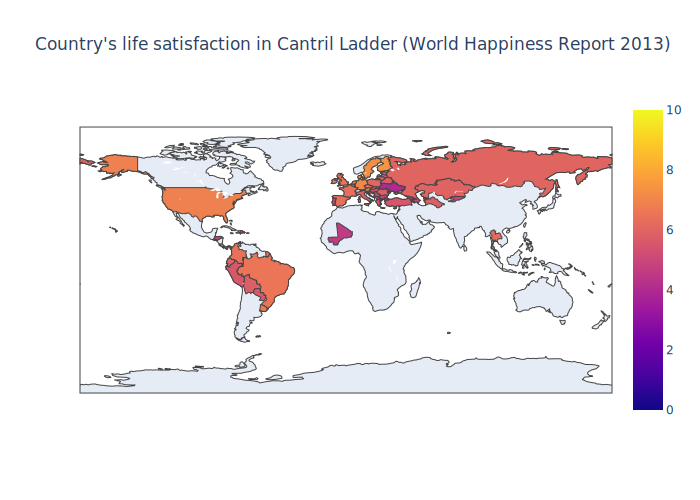

In [33]:
#Visualize Dataset df_unique_ginis on map
choropleth_fig = px.choropleth(df_unique_ginis.query("Year==2013"), 
                    title="Country's life satisfaction in Cantril Ladder (World Happiness Report 2013)",
                    locations="Code", color="Life Satisfaction",
                    color_continuous_scale=["red", "light blue", "yellow"],
                    range_color=(0, 10),
                    scope="world", hover_name="Entity",
                    hover_data={"Entity": True, "Code": False, "Life Satisfaction": False, "Gini index": False, },)
choropleth_fig.update_traces(hovertemplate = 'Country: %{customdata[0]}<br>Happiness: %{customdata[2]}<br>Gini: %{customdata[3]}<extra></extra>')
choropleth_fig.update_layout(coloraxis_colorbar=dict(title="",))
choropleth_fig.show("svg")

b) Scatterplots for individual countries

The weakness of the choropleth map was that development of Life Satisfaction, GDP per capita and Gini index could not be tracked over time. Furthermore, the Gini index, although available, wasn't immediately visible and could therefore not be compared as easily. Instead, a scatterplot with Life Satisfaction on the y-axis and GDP per capita on the x-axis was drawn up and contrasted with a seperate second graph where GDP per capita was replaced with the Gini index on the x-axis. Unfortunately, in this way, time could not be visualized on the x-axis like in a classic time series graph without removing one of the other statistics. The solution to this problem was to visualize time in arrow form. The tail of an arrow would be placed on the chronologically first year's data point, while its head would point towards the datapoint representing the year after. This was done for each datapoint. A red ordinary least squares trendline was included to allow for an instant visualization of the initial conclusion provided by the graph. The title of the graph as well as the axis titles provided almost all relevant information. The year of each datapoint was placed to the bottom right of the point to enable smoother reading and less crossover. The symbols (diamond) and size of the symbols were chosen carefully to allow for information to be clearly read and understood. The color of the arrows (black) and symbols (blue) contrast with the red trendline while also seperating themselves from each other. Hoverframes were removed to avoid confusion, as all relevant information was already portrayed.

In [10]:
#Function for visualizing scatterplots of Happiness/GDP Data with arrows tracing chronologically for countries of choice
def arrow_scatterplot_gdp(code, df):
    df_country = df[df['Code'] == code]
    scatter_country_gdp_fig = px.scatter(df_country, x = 'GDP per capita', y = 'Life Satisfaction',
                                         symbol_sequence=["diamond"], text = 'Year', 
                                         trendline='ols', trendline_color_override = "red", 
                                         title="Life Satisfaction/GDP per capita Scatterplot (" +df[df['Code'] == code]['Entity'].tolist()[0]+ ")")
    scatter_country_gdp_fig.update_traces(textposition="bottom right", textfont_size=15,
                                          hovertemplate=None, hoverinfo='skip',
                                          marker={'size': 10})
    for t in range(len(df_country)-1):
        scatter_country_gdp_fig.add_annotation(
            x= df_country.iloc[t+1]['GDP per capita'],  # arrows' head
            y=df_country.iloc[t+1]['Life Satisfaction'],  # arrows' head
            ax=df_country.iloc[t]['GDP per capita'],  # arrows' tail
            ay=df_country.iloc[t]['Life Satisfaction'],  # arrows' tail
            xref='x',
            yref='y',
            axref='x',
            ayref='y',
            text='',
            showarrow=True,
            arrowhead=1,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='black'
        )
    return scatter_country_gdp_fig

In [11]:
#Function for visualizing scatterplots of Happiness/Gini Data with arrows for countries of choice
def arrow_scatterplot_gini(code, df):
    df_country = df[df['Code'] == code]
    scatter_country_gini_fig = px.scatter(df_country, x = 'Gini index', y = 'Life Satisfaction',
                                          symbol_sequence=["diamond"], text = 'Year',
                                          trendline='ols', trendline_color_override = "red",
                                          title="Life Satisfaction/Gini index Scatterplot (" +df[df['Code'] == code]['Entity'].tolist()[0]+ ")")
    scatter_country_gini_fig.update_traces(textposition="bottom right", textfont_size=15,
                                          hovertemplate=None, hoverinfo='skip',
                                          marker={'size': 10})
    for t in range(len(df_country)-1):
        scatter_country_gini_fig.add_annotation(
            x= df_country.iloc[t+1]['Gini index'],  # arrows' head
            y=df_country.iloc[t+1]['Life Satisfaction'],  # arrows' head
            ax=df_country.iloc[t]['Gini index'],  # arrows' tail
            ay=df_country.iloc[t]['Life Satisfaction'],  # arrows' tail
            xref='x',
            yref='y',
            axref='x',
            ayref='y',
            text='',
            showarrow=True,
            arrowhead=1,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='black'
        )
    return scatter_country_gini_fig

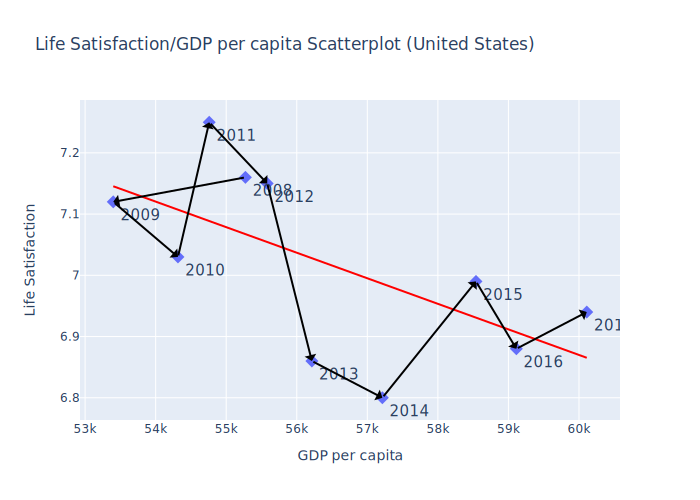

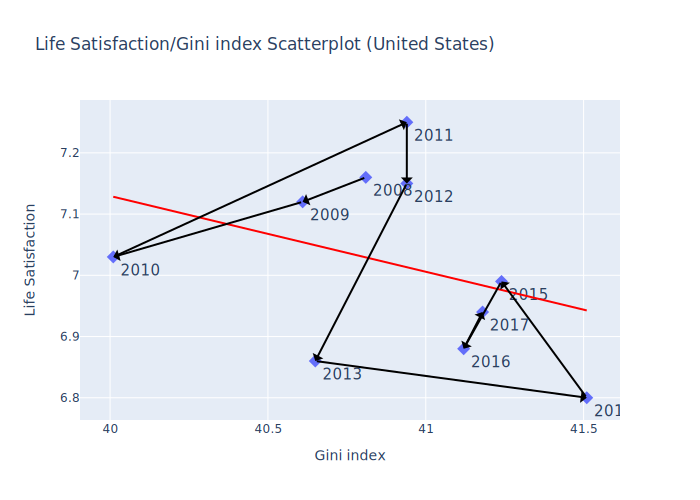

In [32]:
arrow_scatterplot_gdp("USA", df).show("svg")
arrow_scatterplot_gini("USA", df).show("svg")

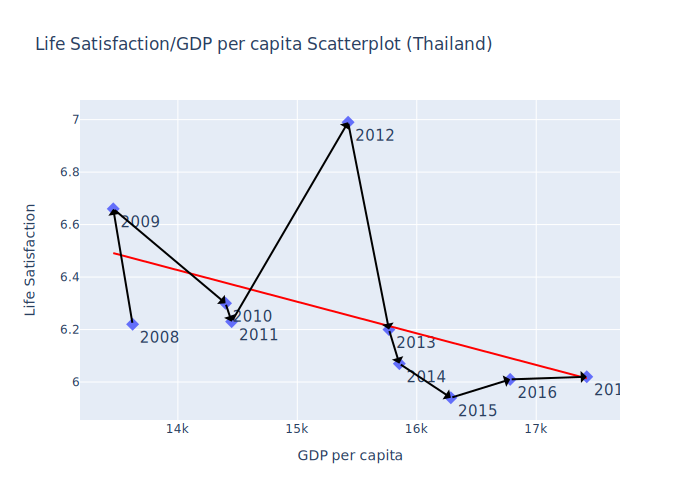

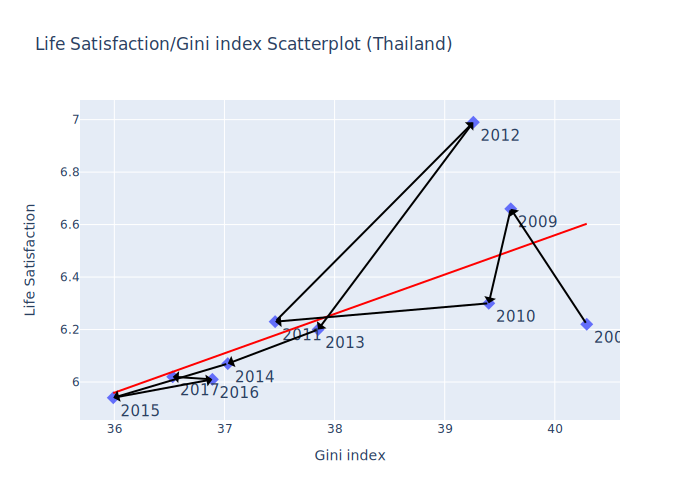

In [31]:
arrow_scatterplot_gdp("THA", df).show("svg")
arrow_scatterplot_gini("THA", df).show("svg")

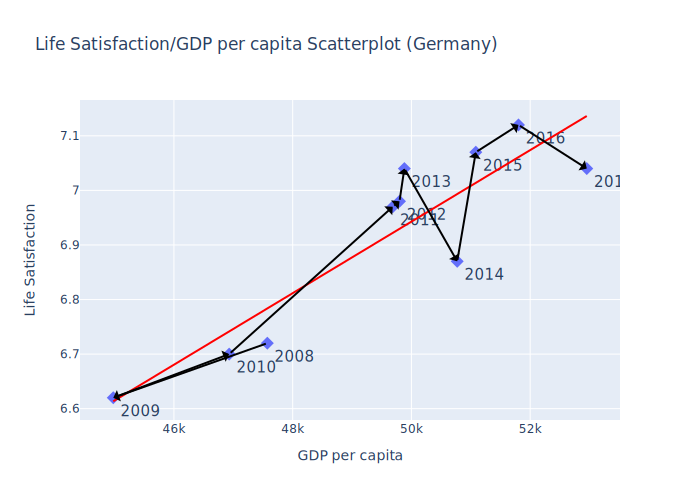

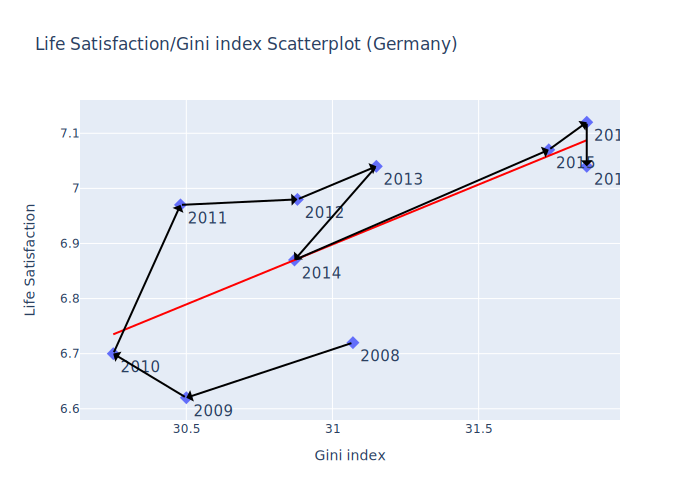

In [30]:
arrow_scatterplot_gdp("DEU", df).show("svg")
arrow_scatterplot_gini("DEU", df).show("svg")

c) Scatterplot comparing all countries

The previous scatterplots now included a visualization of development over time. Unfortunately, in this way, countries could only be portrayed individually. Also, the viewer was forced to read two seperate graphs in order to compare GDP per capita development and Gini index development. Therefore another scatterplot was developed. It aimed to capture every country's development over time in GDP per capita, Gini index and Life Satisfaction, allowing for instant comparison with each other. In order to achieve this, a seperate dataframe was created that recorded GDP per capita, Gini index and Life Satisfaction data in three different ways: 1) as they stood in the last recorded year (2017), 2) the change over a ten year period in percent, from the first recording in 2008 until the last recording in 2017, 3) as either above or below a threshold which was chosen on the basis of effectively dividing countries into two seperate groups. The threshold for GDP per capita was set a $35,000 (roughly rich vs. poor). The threshold for Gini index was set a 34 (roughly equal vs. unequal). The threshold for Life Satisfaction was set at 6 (roughly happy vs. unhappy).

In [15]:
df_developments = pd.DataFrame(columns=['Code',
                                        'Country',
                                        'Continent',
                                        'Population',
                                        'GDP per capita 2017',
                                        'Gini index 2017',
                                        'Life Satisfaction 2017',
                                        'Change GDP per capita',
                                        'Change Gini index',
                                        'Change Life Satisfaction', 
                                        'GDP per capita threshold',   
                                        'Gini index threshold',
                                        'Life Satisfaction threshold'])

for i in df_unique_ginis["Code"].unique():
    df_country = df[df['Code'] == i]
    country_code = i
    country_name = df_country.iloc[-1,0]
    continent = df_country.iloc[-1,7]
    population = df_country.iloc[-1,5]
    gdp_pc_2017 = df_country.iloc[-1,4]
    gini_index_2017 = df_country.iloc[-1,6].round(0)
    life_satisfaction_2017 = df_country.iloc[-1,3]
    change_gdp_pc = ((df_country.iloc[-1,4] - df_country.iloc[0,4])/df_country.iloc[0,4]) * 100
    change_gini_index = ((df_country.iloc[-1,6] - df_country.iloc[0,6])/df_country.iloc[0,6]) * 100
    change_life_satisfaction = (((df_country.iloc[-1, 3] - df_country.iloc[0, 3]) / df_country.iloc[0, 3])+1)**10
    if gdp_pc_2017 > 35000:
        gdp_pc_threshold = "above"
    else:
        gdp_pc_threshold = "below"
    if gini_index_2017 > 34:
        gini_index_threshold = "above"
    else:
        gini_index_threshold = "below"
    if life_satisfaction_2017 > 6:
        life_satisfaction_threshold = "above"
    else:
        life_satisfaction_threshold = "below"
    df_developments.loc[len(df_developments)] = [country_code,
                                                 country_name,
                                                 continent, population,
                                                 gdp_pc_2017, gini_index_2017,
                                                 life_satisfaction_2017, change_gdp_pc,
                                                 change_gini_index,change_life_satisfaction,
                                                 gdp_pc_threshold,
                                                 gini_index_threshold,
                                                 life_satisfaction_threshold]
    

Change in GDP per capita from 2008-2017 was recorded on the x-axis. Change in Gini index from 2008-2017 was recorded on the y-axis. Change in Life Satisfaction from 2008-2017 was recorded in the size of the symbols (small symbol = low growth or shrinkage, large symbol = high growth). Additionally, the types of symbols and symbol colors could be used to record a country being either above or below the determined threshold for GDP per capita, Gini index or Life Satisfaction. These could be combined in several different ways to visualize different pieces of information that could be extracted from the data. All this information can be determined from the title, subtitle and legends which were included in the graph for clarity. Symbols (diamond and circle), symbol size (restricted to 50) and colors (blue and red) were chosen to allow for a clear reading of the graph. Using scales instead of thresholds in combination with several different colors and symbols made the graph too complicated to read. Thresholds allowed for easy extraction of information. Labels only included the country code to the bottom right of the data point as the entire name of each country would have taken up too much space. However, it was important to include the country code in order to enable a quick understanding of the graph. The hover function which could have allowed information such as country name etc. to be included in a different way was disabled to avoid making the reading of the graph too strenuous and time consuming. 

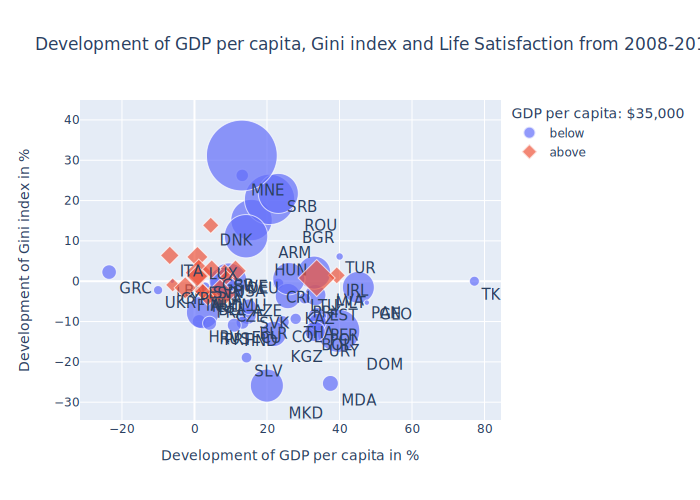

In [29]:
#symbols and color of symbols indicate if a country is above or below GDP per capita threshold of $35,000
#size of symbols indicates development of Life Satisfaction (small symbol = low growth / shrinkage, large symbol = high growth)
def scatter_changes_gdp_gini_gdp_threshold(df_developments):
    scatter_changes_gdp_gini_fig = px.scatter(df_developments, x = 'Change GDP per capita', y = 'Change Gini index',
                                              text = 'Code', color = 'GDP per capita threshold',
                                              symbol = 'GDP per capita threshold', symbol_sequence = ['circle', 'diamond'],
                                              size = 'Change Life Satisfaction', size_max = 50,
                                              title = "Development of GDP per capita, Gini index and Life Satisfaction from 2008-2017 <br><sup>Size of symbols indicates development of Life Satisfaction (small symbol = low growth or shrinkage, large symbol = high growth)</sup>", 
                                              labels = {"Change GDP per capita": "Development of GDP per capita in %",
                                                        "Change Gini index": "Development of Gini index in %", 
                                                        "GDP per capita threshold": "GDP per capita: $35,000"})
    scatter_changes_gdp_gini_fig.update_traces(textposition="bottom right", textfont_size=15,
                                              hovertemplate=None, hoverinfo='skip')
    scatter_changes_gdp_gini_fig.show("svg")

scatter_changes_gdp_gini_gdp_threshold(df_developments)

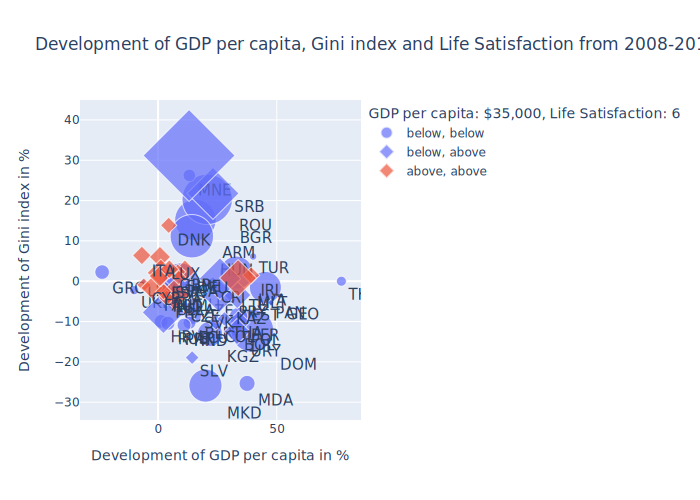

In [28]:
#symbols indicate if a country is above or below Life Satisfaction threshold of 6 (circle = below, diamond = above)
#color of symbols indicate if a country is above or below GDP per capita threshold of $35,000 (blue = below, red = above)
def scatter_changes_gdp_gini_gdp_satisfaction_threshold(df_developments):
    scatter_changes_gdp_gini_fig = px.scatter(df_developments, x = 'Change GDP per capita', y = 'Change Gini index',
                                              text = 'Code', color = 'GDP per capita threshold',
                                              symbol = 'Life Satisfaction threshold', symbol_sequence = ['circle', 'diamond'],
                                              size = 'Change Life Satisfaction', size_max = 50,
                                              title = "Development of GDP per capita, Gini index and Life Satisfaction from 2008-2017 <br><sup>Size of symbols indicates development of Life Satisfaction (small symbol = low growth or shrinkage, large symbol = high growth)</sup>", 
                                              labels = {"Change GDP per capita": "Development of GDP per capita in %",
                                                        "Change Gini index": "Development of Gini index in %",
                                                        "Life Satisfaction threshold": "Life Satisfaction: 6",
                                                        "GDP per capita threshold": "GDP per capita: $35,000"})
    scatter_changes_gdp_gini_fig.update_traces(textposition="bottom right", textfont_size=15,
                                              hovertemplate=None, hoverinfo='skip')
    scatter_changes_gdp_gini_fig.show("svg")

scatter_changes_gdp_gini_gdp_satisfaction_threshold(df_developments)

4) Conclusion

While the choropleth map allowed for a reading of geographical information, the scatterplots for individual countries allowed for a more specific reading of a country's statistics over time. Finally, the scatterplot comparing all countries enabled the viewer to do both. It could be adjusted to contain geographic information (such as using the continent data to determine color), while tracking development over the ten year time period in question. On top of this, thresholds could be included to make clear distinctions between groups without overburdening the viewer with information. 